In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from melp import Detector
import melp
import math

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump

plt.rcParams.update({'font.size': 16})

Welcome to JupyROOT 6.24/06


#### Load files

In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
#file = ROOT.TFile(filename)
#ttree_mu3e = file.Get("mu3e")

In [3]:
file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")

frame = 1
ttree_trirec.GetEntry(frame)
ttree_trirec_mc.GetEntry(frame)
   
tid_rec = ttree_trirec.mc_tid
tid_rec_mc = ttree_trirec_mc.mc_tid

tid_counter = 0
for i in tid_rec_mc:
    if i in get_tid_frame(filename_sorted,1).values():
        tid_counter += 1
    else:
        continue

print(tid_counter/(len(get_tid_frame(filename_sorted,1))/100), "%")
print(len(tid_rec_mc)/(len(tid_rec)/100), "%")

10.526315789473685 %
70.0 %


In [4]:
ttree_mu3e_segs = file_rec.Get("segs")
ttree_mu3e_segs.GetEntry(frame)

segs_rec_tid = ttree_mu3e_segs.tl_n

In [5]:
print(segs_rec_tid)

print(tid_rec)

0
{ 28341, 33517, 32299, 34367, 37051, 16492, 16492, 16492, 25876, 25876 }


#### Whole frame as cluster

In [6]:
"""
file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")

eff_counter = 0
tot_hit_counter = 0
wrong_counter = 0

eff_counter_arr = []
tot_hit_counter_arr = []
wrong_counter_arr = []

for frame in range(ttree_mu3e.GetEntries()):
    tmp_eff_counter = 0
    tmp_tot_hit_counter = 0
    tmp_wrong_counter = 0
    
    primaries = get_mc_primary_for_hit_frame(filename_sorted,frame)
    cluster = frame_as_cluster(filename_sorted,frame)
    tot_hit_counter += len(cluster)
    tmp_tot_hit_counter += len(cluster)
    for key in cluster.keys():
        if key in primaries.keys():
            if cluster[key] == primaries[key]:
                eff_counter += 1
                tmp_eff_counter += 1
            else:
                wrong_counter += 1
                tmp_wrong_counter += 1
        else:
            continue
        eff_counter_arr.append(tmp_eff_counter)
        tot_hit_counter_arr.append(tmp_tot_hit_counter)
        wrong_counter_arr.append(tmp_wrong_counter)
             
print("Average number of hits per frame: ", tot_hit_counter/ttree_mu3e.GetEntries())
print("Correctly identified: ", eff_counter/(tot_hit_counter/100), "%")
print("Incorrectly identified (not an actual part of cluster): ", wrong_counter/(tot_hit_counter/100), "%")
print("Not identified (actual part of cluster that hasn't been identified): ", 0, "%")
"""

'\nfile = ROOT.TFile(filename_sorted)\nttree_mu3e = file.Get("mu3e")\nttree_mu3e_mc = file.Get("mu3e_mchits")\n\neff_counter = 0\ntot_hit_counter = 0\nwrong_counter = 0\n\neff_counter_arr = []\ntot_hit_counter_arr = []\nwrong_counter_arr = []\n\nfor frame in range(ttree_mu3e.GetEntries()):\n    tmp_eff_counter = 0\n    tmp_tot_hit_counter = 0\n    tmp_wrong_counter = 0\n    \n    primaries = get_mc_primary_for_hit_frame(filename_sorted,frame)\n    cluster = frame_as_cluster(filename_sorted,frame)\n    tot_hit_counter += len(cluster)\n    tmp_tot_hit_counter += len(cluster)\n    for key in cluster.keys():\n        if key in primaries.keys():\n            if cluster[key] == primaries[key]:\n                eff_counter += 1\n                tmp_eff_counter += 1\n            else:\n                wrong_counter += 1\n                tmp_wrong_counter += 1\n        else:\n            continue\n        eff_counter_arr.append(tmp_eff_counter)\n        tot_hit_counter_arr.append(tmp_tot_hit_co

In [7]:
"""
plt.figure(figsize=(18,10))
plt.hist(tot_hit_counter_arr)
plt.hist(wrong_counter_arr)
plt.hist(eff_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(tot_hit_counter_arr)\nplt.hist(wrong_counter_arr)\nplt.hist(eff_counter_arr)\nplt.show()\n'

In [8]:
"""
plt.figure(figsize=(18,10))
plt.hist(eff_counter_arr + wrong_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(eff_counter_arr + wrong_counter_arr)\nplt.show()\n'

#### Masks (Small. Medium, Big)

In [9]:
mu3e_detector = Detector.initFromROOT("./testdata/sorted/sorted1.root")
#mu3e_detector = Detector.initFromSave("test_detector_file")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [10]:
#mu3e_detector.save("test_detector_file")

In [11]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=<melp.src.tile.TileDetector object at 0x7ff3bf7d9730>, SensorModules=<melp.src.sensor.SensorModule object at 0x7ff3bf6074f0>))


In [12]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [13]:
#select frame to analyze
frame_used = 1

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks = sclump.build_mask_around_cluster_primary(filename_sorted, frame_used, mu3e_detector, mask_type = "big")

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
mu3e_detector.TileDetector.tile[keys[0]].id
mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])

[Hit(edep=0.3654664438059544, mc_i=20001, tid=-1, frame_id=1, run_id=-1, hid=1, impact_vec=None, trajectory=None, pos=None),
 Hit(edep=0.8565486811837582, mc_i=53222, tid=-1, frame_id=70, run_id=-1, hid=1, impact_vec=None, trajectory=None, pos=None),
 Hit(edep=0.5749607961566743, mc_i=171266, tid=-1, frame_id=254, run_id=-1, hid=2, impact_vec=None, trajectory=None, pos=None),
 Hit(edep=0.3829692418692809, mc_i=428912, tid=-1, frame_id=678, run_id=-1, hid=1, impact_vec=None, trajectory=None, pos=None)]

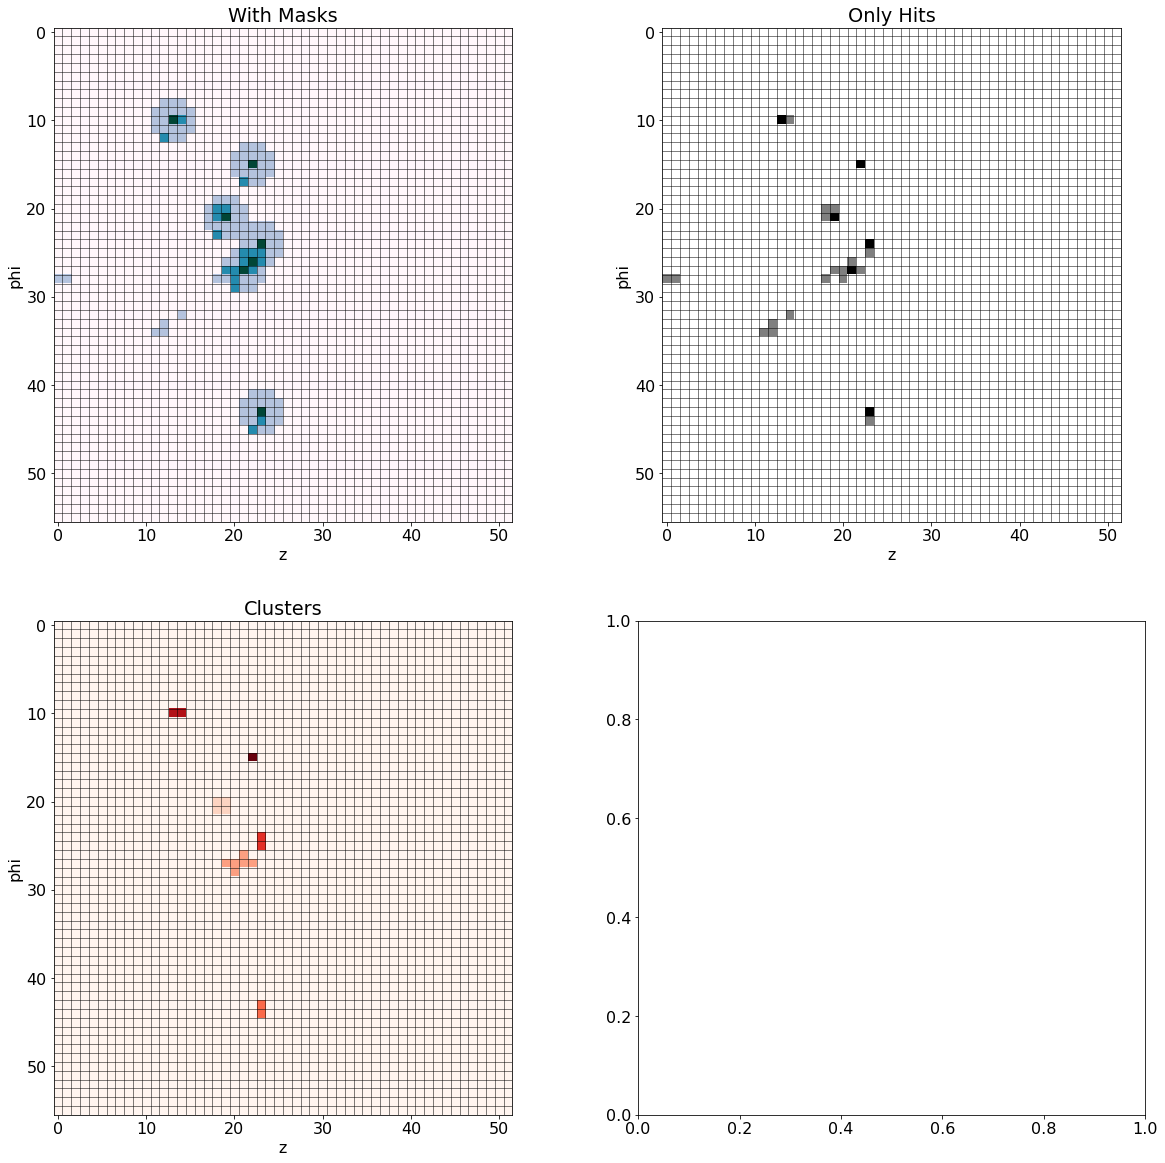

In [14]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    x = tile.row()
                    y = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                x = tile.row()
                y = tile.column()
                grid[x][y] += 1

        #add centre a second time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            x = tile.row()
            y = tile.column()
            grid[x][y] += 1
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            x = tile.row()
            y = tile.column()
            grid[x][y] += 1

    #add centre a second time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        x = tile.row()
        y = tile.column()
        grid[x][y] += 1
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                x = tile.row()
                y = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_primary = get_cluster_primary_truth_frame(filename_sorted, frame_used)  
    
for i in range(len(cluster_primary)):
    primary = mu3e_detector.TileDetector.tile[cluster_primary[i]]
    if primary.id < 300000:
        x = primary.row()
        y = primary.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")


#plot clusters
cluster_grid = np.zeros((52,56))
clusters = sclump.build_clusters_in_masks(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
cluster_primaries = []
whole_clusters = []
for key in clusters.keys():
    cluster_primaries.append(key)
    whole_clusters.append(clusters[key])

color_clusters = 1
for i in range(len(clusters)):
    color_clusters += 1
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile]
        if cluster_tile < 300000:
            x = tile.row()
            y = tile.column()
            cluster_grid[x][y] += i+1

    #add centre    
    if cluster_primaries[i] < 300000:
        tile = mu3e_detector.TileDetector.tile[cluster_primaries[i]]
        x = tile.row()
        y = tile.column()
        cluster_grid[x][y] += i+1
    
    
heatplot = ax[1,0].imshow(cluster_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
#plt.savefig("hitmap.png")
plt.show()

## Efficiency Plots

In [15]:
file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")

#### Hits not included in any cluster

#### Hits associated to wrong cluster

#### Hits correctly associated

In [20]:
def compare_to_primary(filename):
    file = ROOT.TFile(filename)
    ttree_mu3e = file.Get("mu3e")
    
    #comparing to primary
    frac_corr_frame = []
    frac_uncorr_frame = []
    total_hits = []
    #primary_found_counter = 0
    #primary_not_found_counter = 0

    for frame in range(ttree_mu3e.GetEntries()):
        #Printing status info
        if frame % 100 == 0:
            print("Progress: ", np.round(frame / ttree_mu3e.GetEntries() * 100), " %", end='\r')

        ttree_mu3e.GetEntry(frame)
        tot_hits_frame = len(ttree_mu3e.tilehit_tile)
        corr_counter = 0
        uncorr_counter = 0
        
        #get primaries
        primaries_frame = get_mc_primary_for_hit_frame(filename_sorted, frame)
        primaries_frame_arr = []
        for key in primaries_frame.keys():
            primaries_frame_arr.append([key,primaries_frame[key]]) #[hit tile, primary for tile hit]

        #get clusters
        clusters_with_primaries = sclump.build_cluster_with_truth_primary(filename_sorted, frame, mu3e_detector, mask_type = "big")
        cluster_primaries_arr = []
        cluster_arr = []
        for key in clusters_with_primaries.keys():
            cluster_primaries_arr.append(key)
            cluster_arr.append(clusters_with_primaries[key])

        #comparison
        for i in range(len(primaries_frame_arr)):
            for j in range(len(cluster_primaries_arr)):
                if cluster_primaries_arr[j] == primaries_frame_arr[i][1]:
                    #primary_found_counter += 1
                    for k in range(len(cluster_arr[j])):
                        if cluster_arr[j][k] == primaries_frame_arr[i][0]:
                            corr_counter += 1
                        else:
                            uncorr_counter += 1
                #else:
                    #primary_not_found_counter += 1

        if corr_counter != 0:
            frac_corr_frame.append(corr_counter/tot_hits_frame)  

        if uncorr_counter != 0:
            frac_uncorr_frame.append(uncorr_counter/tot_hits_frame)

        total_hits.append(tot_hits_frame)
        
    return frac_corr_frame, frac_uncorr_frame

In [17]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame, bins = 100)
plt.title("Correctly associated hits/All hits (per frame)")
plt.show()

NameError: name 'frac_corr_frame' is not defined

<Figure size 864x432 with 0 Axes>

In [ ]:
print(np.sum(total_hits))
print(np.sum(tot_hit_check))
print(primary_found_counter/primary_not_found_counter)

In [22]:
import cProfile
import pstats
cProfile.run("compare_to_primary(filename_sorted)")

         326098 function calls (326089 primitive calls) in 44.179 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.722    0.722   44.179   44.179 2534438590.py:1(compare_to_primary)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(around)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(round_)
        1    0.000    0.000   44.179   44.179 <string>:1(<module>)
     4206    0.010    0.000    0.017    0.000 _facade.py:169(_fallback_getattr)
     4206    0.774    0.000    0.777    0.000 _tfile.py:45(_TFileConstructor)
       18    0.000    0.000    0.000    0.000 fromnumeric.py:3216(_around_dispatcher)
        9    0.000    0.000    0.000    0.000 fromnumeric.py:3220(around)
        9    0.000    0.000    0.000    0.000 fromnumeric.py:3730(round_)
        9    0.000    0.000    0.000    0.000 fromnumeric.py:38(_wrapit)
        9    0.000    0.000    0.00

In [35]:
%load_ext line_profiler
%lprun -f compare_to_primary compare_to_primary(filename_sorted)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [36]:
def get_cluster_primary_truth_frame(filename, frame):
    file = ROOT.TFile(filename)
    ttree_mu3e = file.Get("mu3e")
    ttree_mu3e_mc = file.Get("mu3e_mchits")

    cluster_primary = []

    ttree_mu3e.GetEntry(frame)
    for i in range(len(ttree_mu3e.tilehit_tile)):
        #tile = ttree_mu3e.tilehit_tile[i]
        #mc_i = ttree_mu3e.tilehit_mc_i[i]
        #ttree_mu3e_mc.GetEntry(mc_i)
        mc_i = ttree_mu3e.tilehit_mc_i[i]
        ttree_mu3e_mc.GetEntry(mc_i)
        hid = ttree_mu3e_mc.hid

        if np.abs(hid) == 1:
            tile = ttree_mu3e.tilehit_tile[i]
            cluster_primary.append(tile)

    return cluster_primary

In [37]:
%reload_ext line_profiler
%lprun -f get_cluster_primary_truth_frame get_cluster_primary_truth_frame(filename_sorted, frame_used)